##### 1. data cleaning, pre-model configuration and uploading to a new csv

In [24]:
# 1.1 importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
# 1.2 reading the csv into a dataframe df_original
df_original = pd.read_csv('/Users/nikgurunathan/Desktop/csv_heart/Heart.csv')

In [26]:
# 1.3 removing duplicates
df_original = df_original.drop_duplicates()
print(df_original.shape)

(444975, 40)


In [27]:
# 1.4 logic checks
invalid_bmi = df_original[(df_original['BMI'] < 10) | (df_original['BMI'] > 80)] # bmi typically ranges from 10 to 50
invalid_sleep = df_original[(df_original['SleepHours'] < 0) | (df_original['SleepHours'] > 24)] # sleep hours must be between 0-24
suspicious_sleep_values = df_original[(df_original['SleepHours'] < 3) | (df_original['SleepHours'] > 22)] # to be capped as outliers

print(f"Invalid BMI entries: {len(invalid_bmi)}")
print(f"Invalid SleepHours entries: {len(invalid_sleep)}")
print(f"Suspicious SleepHours entries to check again: {len(suspicious_sleep_values)}")

# 1.4.1 creating an accurate CalculatedBMI column
df_original['CalculatedBMI'] = df_original['WeightInKilograms'] / (df_original['HeightInMeters'] ** 2)

# 1.4.2 if AgeCategory is '65 or older', they should likely report having one of the following:
    # heart attack, stroke, diabetes
agecategory_inconsistencies = df_original[
    (df_original['AgeCategory'] == '65 or older') &
    ~(df_original[['HadHeartAttack', 'HadStroke', 'HadDiabetes']].any(axis=1))
]
print(f"Number of logical inconsistencies in AgeCategory (age 65+ but no major health conditions): {len(agecategory_inconsistencies)}")

# 1.4.3 if SmokerStatus is 'Yes', they should likely report at least one of the following conditions:
    # heart attack, COPD, asthma, stroke
smoker_inconsistencies = df_original[
    (df_original['SmokerStatus'] == 'current smoker - now smokes every day') | (df_original['SmokerStatus'] == 'current smoker - now smokes some days') | (df_original['SmokerStatus'] == 'former smoker') &
    ~(df_original[['HadHeartAttack', 'HadCOPD', 'HadAsthma', 'HadStroke']].any(axis=1))
]
print(f"Number of logical inconsistencies in SmokerStatus (current or former smoker but no major related health conditions): {len(smoker_inconsistencies)}")

# 1.4.4 if DifficultyWalking is True, then atleast one of the following should also be True:
    # DifficultyDressingBathing, DifficultyErrands
walking_inconsistencies = df_original[
    (df_original['DifficultyWalking'] == True) &
    ~(df_original[['DifficultyDressingBathing', 'DifficultyErrands']].any(axis=1))
]
print(f"Number of logical inconsistencies in DifficultyWalking (difficulty walking but no related difficulties): {len(walking_inconsistencies)}")

#1.4.5 if HadCOPD is True, then atleast one of the following difficulties should also be True:
    # DifficultyWalking, DifficultyDressingBathing, DifficultyErrands
copd_inconsistancies = df_original[
    (df_original['HadCOPD'] == True) &
    ~(df_original[['DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands']].any(axis=1))
]
print(f"Number of logical inconsistencies in COPD (COPD but no difficulties with daily activities): {len(copd_inconsistancies)}")

# 1.4.6 if HadHeartAttack is True, then at least one of Stroke, Angina, or ChestScan should be True
heartattack_inconsistencies = df_original[
    (df_original['HadHeartAttack'] == True) &
    ~(df_original[['HadStroke', 'HadAngina', 'ChestScan']].any(axis=1))  # None of these is True
]
print(f"Number of logical inconsistencies in Heart Attack (Heart Attack but no related conditions reported): {len(heartattack_inconsistencies)}")

# 1.4.7 if SleepHours is less than 4 or more than 12, we expect at least one of the following health conditions to be True:
    # HadDepressiveDisorder, HadHeartAttack, HadAngina, HadStroke, HadSkinCancer, HadAsthma, HadCOPD, HadKidneyDisease, HadArthritis, HadDiabetes, DifficultyConcentrating, HighRiskLastYear
sleep_hours_inconsistencies = df_original[
    ((df_original['SleepHours'] < 5) | (df_original['SleepHours'] > 12)) &
    ~(df_original[['HadDepressiveDisorder', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadSkinCancer', 'HadAsthma', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DifficultyConcentrating', 'HighRiskLastYear']].any(axis=1))  # None of these is True
]
print(f"Number of logical inconsistencies in SleepHours (abnormal sleep but no related health conditions): {len(sleep_hours_inconsistencies)}")

# 1.4.8 if PhysicalHealthDays is 0, they should not report significant limitations in daily activities
physical_health_inconsistencies = df_original[
    (df_original['PhysicalHealthDays'] == 0) &
    ~(df_original[['DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands']].any(axis=1))]  # No difficulty reported
print(f"Number of logical inconsistencies in PhysicalHealthDays (0 health days but activity limitations): {len(physical_health_inconsistencies)}")


Invalid BMI entries: 80
Invalid SleepHours entries: 0
Suspicious SleepHours entries to check again: 2773
Number of logical inconsistencies in AgeCategory (age 65+ but no major health conditions): 0
Number of logical inconsistencies in SmokerStatus (current or former smoker but no major related health conditions): 0
Number of logical inconsistencies in DifficultyWalking (difficulty walking but no related difficulties): 0
Number of logical inconsistencies in COPD (COPD but no difficulties with daily activities): 0
Number of logical inconsistencies in Heart Attack (Heart Attack but no related conditions reported): 0
Number of logical inconsistencies in SleepHours (abnormal sleep but no related health conditions): 4
Number of logical inconsistencies in PhysicalHealthDays (0 health days but activity limitations): 14233


In [28]:
# 1.5 filling in the missing values for the numerical and object columns
df_original.fillna({col: df_original[col].median() for col in df_original.select_dtypes('float64')}, inplace=True)
df_original.fillna({col: df_original[col].mode().iloc[0] for col in df_original.select_dtypes('object')}, inplace=True)

print(df_original.isnull().sum()) # to check

State                        0
Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI     

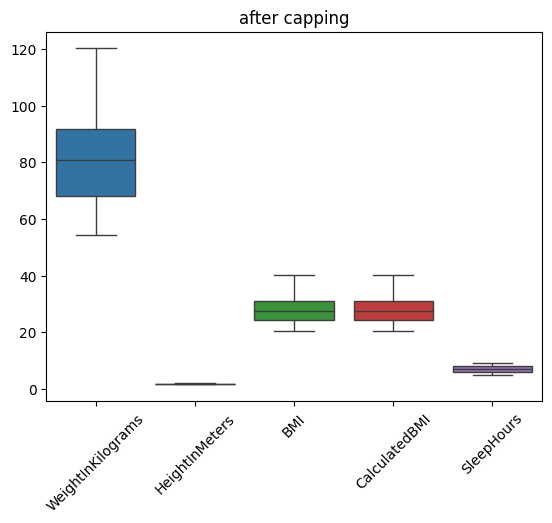

In [29]:
# 1.6 capping outliers
def cap_outliers(df_original, columns, lower_percentile=0.05, upper_percentile=0.95):
    for column in columns:
        lower_bound = df_original[column].quantile(lower_percentile)
        upper_bound = df_original[column].quantile(upper_percentile)

        # after capping
        df_original[column] = df_original[column].apply(lambda x: min(max(x, lower_bound), upper_bound))

    return df_original

# list of columns to cap
columns_to_cap = ['WeightInKilograms', 'HeightInMeters', 'BMI', 'CalculatedBMI', 'SleepHours']

# apply the capping
df_cleaned = cap_outliers(df_original, columns_to_cap)

# verification of capping
sns.boxplot(data=df_original[columns_to_cap])
plt.title("after capping")
plt.xticks(rotation=45)
plt.show()

In [30]:
for col in df_original.select_dtypes(include=['category', 'object']).columns:
    df_original[col] = df_original[col].str.strip().str.lower()

In [31]:
cleaned_df = df_original.drop_duplicates()

In [32]:
cleaned_df.to_csv('CleanedHeart.csv', index=False)

In [34]:
cleaned_df = pd.read_csv('/Users/nikgurunathan/Desktop/csv_heart/final_draft/CleanedHeart.csv')

2. ##### pre-model configuration

In [43]:
# 2.1 converting yes/no columns to numeric
def string_to_numeric(entry):
    if isinstance(entry, str):
        if entry == 'yes':
            return 1
        elif entry == 'no':
            return 0
        elif entry == 'no, pre-diabetes or borderline diabetes':
            return 0.5
        else:
            return entry
    
    cleaned_df = cleaned_df.applymap(string_to_numeric)


In [44]:
cleaned_df.to_csv('CleanedHeart.csv', index=False)

In [35]:
# 2.2 initialising the RiskScore column

cleaned_df['RiskScore'] = 0

from most to least disruptive:
* stroke = 10 pts
* heart attack = 9.5 pts
* COPD = 9 pts
* depressive disorder = 8.5 pts
* blind / vision difficulty = 8.5 pts
* difficulty dressing and bathing = 8.5 pts
* angina = 8 pts
* arthritis = 7.5 pts
* kidney disease = 7.5 pts
* difficulty concentrating = 7 pts
* diabetes = 7 pts
* asthma = 6.5 pts
* difficulty running errands = 6 pts
* deaf / hard of hearing = 6 pts
* skin cancer = 5.5 pts
* calculated bmi < 18.5 - 5 pts
* calculated bmi > 24.9 = 4.5 pts 
(bmi normal range is 18.5-24.9)
* smoker status: current smoker - now smokes every day = 4.5 pts
* e-cigarette usage - use them every day = 4 pts
* smoker status: current smoker - now smokes some days = 3.5 pts
* e-cigarette usage: use them some days - 3 pts
* smoker status: former smoker = 2.5 pts
* e-cigarette usage: not at all (right now) = 2 pts
* smoker status: never smoked = 2 pts
* e-cigarette usage: never used e-cigarettes in my entire life = 2 pts
* alcohol drinkers = 2 pts
* sleep hours < 7 hours = 1.5 pts

In [36]:
#2.3 ranking the health/lifestyle risk factors in order from most to least disruptive to daily life and assigning points
# see markdown above for full list and point allocations

cleaned_df['RiskScore'] = cleaned_df['RiskScore'] + (10 * cleaned_df['HadStroke']) # stroke
# cleaned_df['RiskScore'] = cleaned_df['RiskScore'] + (9.5 * cleaned_df['HadHeartAttack']) # heart attack
# cleaned_df['RiskScore'] = cleaned_df['RiskScore'] + (9 * cleaned_df['HadCOPD']) # COPD
# cleaned_df['RiskScore'] = cleaned_df['RiskScore'] + (8.5 * cleaned_df['HadDepressiveDisorder']) # depressive disorder

TypeError: unsupported operand type(s) for +: 'int' and 'str'